### Aim to experiment the model with test signal
#### follow the dashed black line
<img src="../model_structure.jpg" alt="model_structure" width="600" />

In [1]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath('../models'))

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


In [3]:
#########################
#DCAE loading
##########################
from DCAE import Autoencoder
from gaps_generation import ge_unsche

# Create an instance of the autoencoder
autoencoder = torch.load('../models/models_dcae.pth')

In [5]:
######################
#BI_GRU loading
######################
from bi_GRU import BidirectionalGRUModel

# Create an instance of the bi-GRU
model = torch.load('../models/models_ae_gru.pth')

# Print the autoencoder architecture
print(model)

BidirectionalGRUModel(
  (gru): GRU(1, 12, num_layers=2, batch_first=True, bidirectional=True)
  (fc2): Tanh()
  (fc1): Linear(in_features=24, out_features=1, bias=True)
)


#### We consider different scenarios where the test signal is corrupted with gaps.

In [6]:
###############
## test signal
###############
tmax =  3*24*60*60                 # Final time

fs = 2*1e-3                     # Sampling rate
delta_t = 5
t = np.arange(0,tmax,delta_t)     # Form time vector from t0 = 0 to t_{n-1} = tmax. Length N [include t = zero]

a_true = 5e-21
f_true = 1e-3
fdot_true = 1e-8
testsig=a_true *(np.sin((2*np.pi)*(f_true*t + 0.5*fdot_true * t**2)))


(51840,)

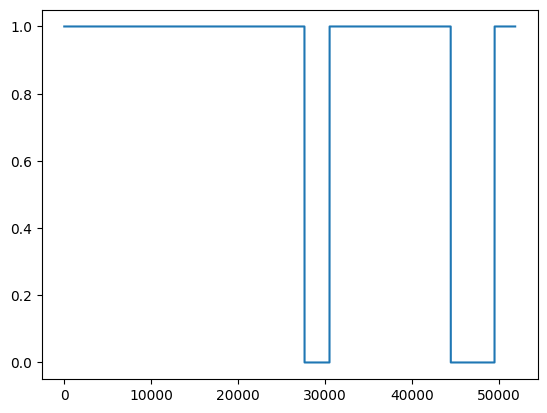

In [10]:
#####################
## signal corruption
#####################
cortestmask=ge_unsche(t)
plt.plot(cortestmask)
maskinautoencoder=cortestmask != 0
maskinautoencoder = maskinautoencoder.astype(int)

cortestsig=testsig*maskinautoencoder
cortestsig.shape

In [11]:
#####################
# DCAE
#####################
testinput=torch.tensor(testsig.reshape((1,1,-1)))
snodata,normaldata,mean,std= autoencoder.signal_preprocess(testinput,maskinautoencoder)
output_normalized_sig=autoencoder(snodata)
outputae=output_normalized_sig.detach().numpy()

#####################
# BI-GRU
#####################
outputaenew=outputae.reshape(-1,48,1) ## DATA segmentation
outputrnn=model(torch.tensor(outputaenew))
outputrnn=outputrnn.reshape(-1,1)
forcast=outputrnn.detach().numpy()
# orgin=outputarrnew
forcast.shape


(51840, 1)

In [12]:
#####################
# Back transformation
#####################
forcastfinalae=autoencoder.signal_backprocess(output_normalized_sig,mean,std)
forcastfinalae=forcastfinalae.reshape(-1,1)
forcastae=forcastfinalae.detach().numpy()

forcastfinal=autoencoder.signal_backprocess(outputrnn*1.5,mean,std)
forcastfinal=forcastfinal.detach().numpy()
forcastoutput=testsig*maskinautoencoder+forcastfinal[:,0]*(1-maskinautoencoder)


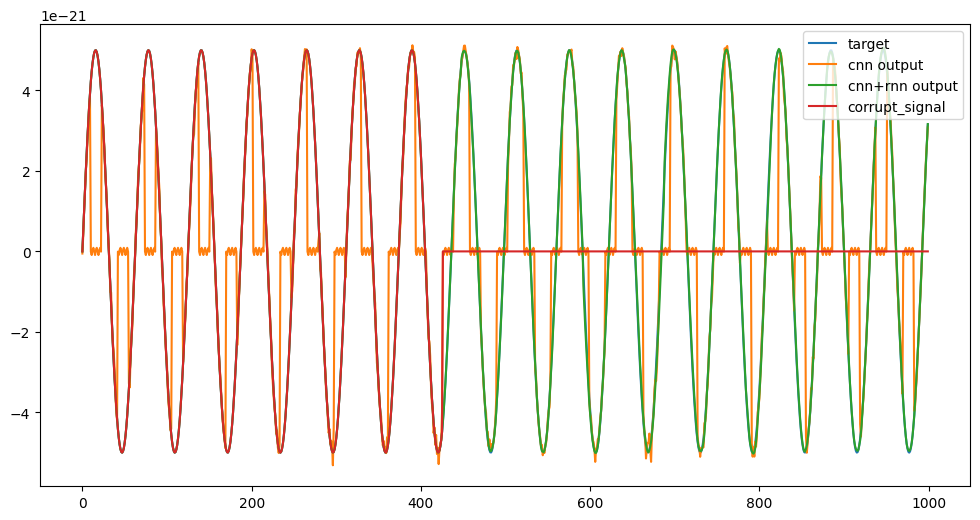

In [14]:
##########################
# final output comparsion
##########################
plt.figure(figsize=(12, 6))
plt.plot(testsig[44000:45000],label="target")
plt.plot(forcastae[44000:45000],label="cnn output")
plt.plot(forcastoutput[44000:45000],label="cnn+rnn output")
plt.plot(cortestsig[44000:45000],label="corrupt_signal")
plt.legend()